Welcome Fashion Recommender across Season

Steps needed build Season Collection:
1.   Convert images to embeddings
2.   Conduct Transfer Learning from ResNet
3.   Use Fastai hooks to retrieve image embeddings from step 2
4.   Use Approximate Nearest Neighbors and embeddings centroid detection to obtain most similar images based on the embeddings from step 3.
5.   Combine the collections with weights

Results: We can merge seasonal collections based on weights


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Initial Setup

In [3]:
# Run this cell and select the kaggle.json file downloaded
# from the Kaggle account settings page.
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nikunjaparida","key":"f82ab329b12eecda16b2d9a4c4e53d77"}'}

In [4]:
# Next, install the Kaggle API client.
!pip install -q kaggle

In [5]:
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
# List available datasets.
!kaggle datasets list

ref                                                         title                                               size  lastUpdated                 downloadCount  voteCount  usabilityRating  
----------------------------------------------------------  --------------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
atharvasoundankar/chocolate-sales                           Chocolate Sales Data 📊🍫                            14473  2025-03-19 03:51:40.270000          17271        295  1.0              
adilshamim8/student-depression-dataset                      Student Depression Dataset                        467020  2025-03-13 03:12:30.423000           8488        126  1.0              
meleknur/global-internet-usage-by-country-2000-2023         Global Internet Usage by Country (2000-2023)       17617  2025-03-25 15:34:00.883000           1444         22  1.0              
abdulmalik1518/mobiles-dataset-2025               

In [7]:
import os
import kagglehub

# Download latest version
#path = kagglehub.dataset_download("paramaggarwal/fashion-product-images-small")

#print("Path to dataset files:", path)

In [8]:

import pandas as pd
import torch
import numpy as np
import os
gpu = torch.cuda.is_available()
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)

if not gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
    print(gpu_info)

CUDA is not available.  Training on CPU ...


In [9]:
import pandas as pd
import numpy as np
import os
import keras
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split # split for validation sets
from sklearn.preprocessing import normalize # normalization of the matrix
from scipy.signal import convolve2d # convolutionof the 2D signals
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from PIL import Image
from io import BytesIO
from skimage.transform import resize
import cv2
import scipy
from tqdm.auto import tqdm, trange

import tensorflow as tf
import tensorflow.keras as keras
import requests

from tensorflow.keras.layers import Activation, Layer
from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import VGG19

import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Add, Input, Concatenate
from keras.models import Model
from keras import preprocessing
from keras.layers import GlobalMaxPooling2D
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions

tf.version.VERSION




'2.18.0'

In [10]:
dataset_path='/content/drive/MyDrive/e-comerce/'
file_csv_path='/content/drive/MyDrive/e-comerce/styles/'
image_path ='/content/drive/MyDrive/e-comerce/images/'
os.listdir(dataset_path)

['styles',
 '.ipynb_checkpoints',
 'images.zip',
 'images',
 'df_summer_woman_ethinic.csv',
 'df_summer_man_casual.csv',
 'df_fall_woman_casual.csv',
 'df_fall_man_formal.csv']

In [11]:
df = pd.read_csv(file_csv_path + "styles.csv")

In [41]:
# Add columns
df['images'] = df.apply(lambda row: str(row['id']) + ".jpg", axis=1)

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4772 entries, 43 to 44312
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  4772 non-null   int64  
 1   gender              4772 non-null   object 
 2   masterCategory      4772 non-null   object 
 3   subCategory         4772 non-null   object 
 4   articleType         4772 non-null   object 
 5   baseColour          4772 non-null   object 
 6   season              4772 non-null   object 
 7   year                4772 non-null   float64
 8   usage               4772 non-null   object 
 9   productDisplayName  4772 non-null   object 
 10  images              4772 non-null   object 
dtypes: float64(1), int64(1), object(9)
memory usage: 447.4+ KB


In [43]:
df.isnull().sum()

,0
id,0
gender,0
masterCategory,0
subCategory,0
articleType,0
baseColour,0
season,0
year,0
usage,0
productDisplayName,0


In [44]:
df['baseColour'] = df['baseColour'].fillna(df['baseColour'].mode().iloc[0])
df['season'] = df['season'].fillna(df['season'].mode().iloc[0])
df['year'] = df['year'].fillna(df['year'].mode().iloc[0])
df['baseColour'] = df['baseColour'].fillna(df['baseColour'].mode().iloc[0])
df['usage'] = df['usage'].fillna(df['usage'].mode().iloc[0])

In [63]:
df.isnull().sum()

,0
id,0
gender,0
masterCategory,0
subCategory,0
articleType,0
baseColour,0
season,0
year,0
usage,0
productDisplayName,7


In [119]:
df_summer_woman_ethinic = df[(df["season"] == 'Summer') & (df["gender"] == 'Women') & (df["masterCategory"] == 'Apparel')  & (df['articleType']=='Kurtas') & (df['usage'] =='Ethnic') ]
df_fall_woman_casual = df[(df["season"] == 'Fall') & (df["gender"] == 'Women') & (df["masterCategory"] == 'Apparel')  & (df['articleType']=='Tshirts') & (df['usage'] =='Casual') ]
df_fall_man_formal = df[(df["season"] == 'Fall') & (df["gender"] == 'Men') & (df["masterCategory"] == 'Apparel')  & (df['articleType']=='Shirts') & (df['usage'] =='Formal') ]
df_summer_man_casual = df[(df["season"] == 'Summer') & (df["gender"] == 'Men') & (df["masterCategory"] == 'Apparel')  & (df['articleType']=='Tshirts') & (df['usage'] =='Casual') ]


In [120]:
frames = [df_summer_woman_ethinic, df_fall_woman_casual,df_fall_man_formal,df_summer_man_casual]
df.head(10)

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,images
43,28690,Women,Apparel,Topwear,Kurtas,Beige,Summer,2012.0,Ethnic,W Women Printed Beige Kurta,28690.jpg
52,45856,Women,Apparel,Topwear,Kurtas,Brown,Summer,2012.0,Ethnic,Vishudh Women Brown Kurta,45856.jpg
122,54588,Women,Apparel,Topwear,Kurtas,Green,Summer,2012.0,Ethnic,Sushilas Women Printed Green Kurta,54588.jpg
191,24406,Women,Apparel,Topwear,Kurtas,Red,Summer,2012.0,Ethnic,Vishudh Women Red Printed Kurta,24406.jpg
224,42426,Women,Apparel,Topwear,Kurtas,Sea Green,Summer,2012.0,Ethnic,Aurelia Women Sea Green Kurta,42426.jpg
249,50325,Women,Apparel,Topwear,Kurtas,Navy Blue,Summer,2012.0,Ethnic,Aurelia Women Navy Blue Kurta,50325.jpg
258,31312,Women,Apparel,Topwear,Kurtas,Peach,Summer,2012.0,Ethnic,W Women Peach Kurta,31312.jpg
312,33021,Women,Apparel,Topwear,Kurtas,Cream,Summer,2012.0,Ethnic,Mother Earth Women Printed Cream Kurta,33021.jpg
398,33019,Women,Apparel,Topwear,Kurtas,Yellow,Summer,2012.0,Ethnic,Mother Earth Women Printed Yellow Kurta,33019.jpg
426,28697,Women,Apparel,Topwear,Kurtas,Black,Summer,2012.0,Ethnic,W Women Printed Black Kurta,28697.jpg


In [121]:
# Number of men's items vs Number of women's items
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
colors = {
    'Men': px.colors.sequential.RdBu[0],
    'Women': px.colors.sequential.RdBu[1],
    'Boys': px.colors.sequential.RdBu[2],
    'Girls': px.colors.sequential.RdBu[3],
    'Unisex': px.colors.sequential.RdBu[4]
    }

fig = px.histogram(df, df['gender'],color='gender', barmode='group',
             title="Number of men's items vs Number of women's items")

fig.show()

In [122]:
articles=pd.value_counts(df['articleType'])
fig = go.Figure([go.Bar(x=articles.index, y=articles.values , text=articles.values,marker_color='indianred')])
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.show()

<ipython-input-122-4e9ab0a59083>:1: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.



<Axes: xlabel='gender', ylabel='count'>

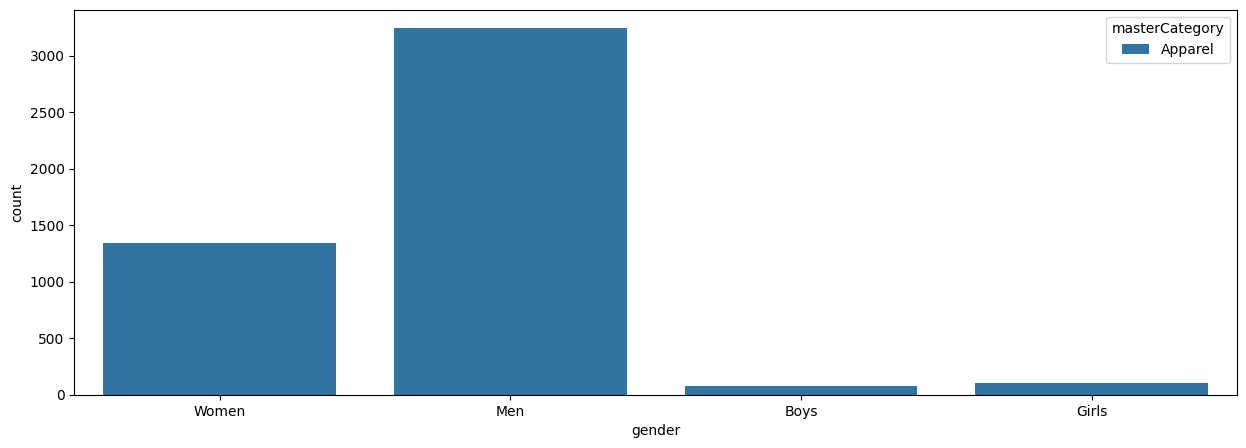

In [123]:
plt.figure(figsize=(15, 5))
sns.countplot(data=df, x=df['gender'], hue=df['masterCategory'])

In [124]:
seasons_counts=pd.value_counts(df['season'])

fig = go.Figure(data=[go.Scatter(
    x=seasons_counts.index, y=seasons_counts.values,
    mode='markers',
    marker=dict(
        color=['rgb(93, 164, 214)', 'rgb(255, 144, 14)',
               'rgb(44, 160, 101)', 'rgb(255, 65, 54)'],
        opacity=[1, 0.8, 0.6, 0.4],
        size=[40, 60, 80, 100])
)])
fig.show()

<ipython-input-124-d6e7edc45e38>:1: FutureWarning:

pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.



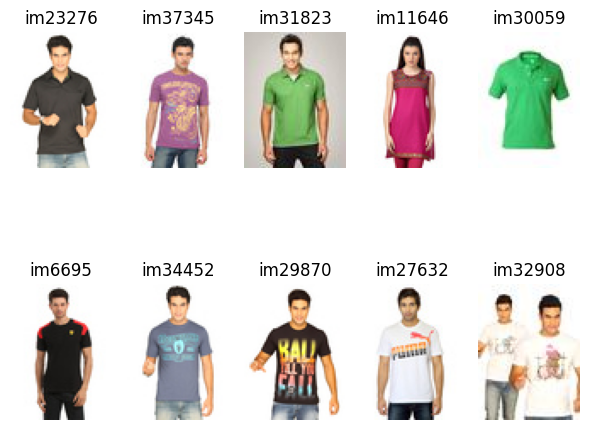

In [125]:

import cv2 as cv
def show_images(figures, nrows = 1, ncols=1,figsize=(6, 6)):
    fig, ax = plt.subplots(ncols=ncols, nrows=nrows,figsize=figsize)
    for ind,title in enumerate(figures):
        ax.ravel()[ind].imshow(cv.cvtColor(figures[title], cv.COLOR_BGR2RGB))
        ax.ravel()[ind].set_title(title)
        ax.ravel()[ind].set_axis_off()
    plt.tight_layout()

def img_path(img_name):
    return image_path + img_name

def load_image(img_name, resized_fac = 0.1):
    img = cv.imread(img_path(img_name))
    # w, h, _ = img.shape
    # resized = cv2.resize(img, (int(h*resized_fac), int(w*resized_fac)), interpolation = cv2.INTER_AREA)
    return img


figures = {'im'+str(i): load_image(row['images']) for i, row in df.sample(10).iterrows()}
#print(figures)
show_images(figures, 2, 5)


In [ ]:
#!ls "/content/drive/My Drive/"
#!unzip -q "/content/drive/My Drive/e-comerce/images.zip"
#!rm  -rf "/content/images/"

In [126]:
#load_image(df.iloc[0].image).shape
img_width, img_height, _ = 128, 128, 3
# Pre-Trained Model
base_model_ResNet50 = ResNet50(weights='imagenet', include_top=False, input_shape = (img_width, img_height, 3))

In [127]:
base_model_ResNet50.trainable = False

# Add Layer Embedding
model = keras.Sequential([
    base_model_ResNet50,
    GlobalMaxPooling2D()
])

In [128]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 4, 4, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling2d_1               │ (None, 2048)                │               0 │
│ (GlobalMaxPooling2D)                 │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

In [129]:
def create_embedding(model, img_name):
    # Reshape
    img = image.load_img(img_path(img_name), target_size=(img_width, img_height))
    # img to Array
    x   = image.img_to_array(img)
    # Expand Dim (1, w, h)
    x   = np.expand_dims(x, axis=0)
    # Pre process Input
    x   = preprocess_input(x)

    predict = model.predict(x).reshape(-1)
    return predict

In [130]:
#df.head(10)
emb = create_embedding(model, df.iloc[6].images)
print(emb)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
[ 0.        14.274969   2.705863  ...  0.         3.7814856 17.384827 ]


(80, 60, 3)


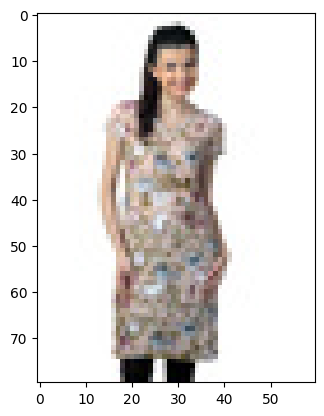

In [131]:
img_array = load_image(df.iloc[6].images)
plt.imshow(cv.cvtColor(img_array, cv.COLOR_BGR2RGB))
print(img_array.shape)

In [132]:
# Get embedding
def get_embedding(df):
    df_tmp = df
    df_emb = df_tmp['images'].apply(lambda img: create_embedding(model, img))
    df_emb = df_emb.apply(pd.Series)
    return df_emb

In [133]:
# Create embeddings for all categories
#df_summer_woman_ethinic_emb = get_embedding(df_summer_woman_ethinic)
print(df_summer_woman_ethinic.columns)
df_summer_woman_ethinic_emb = pd.read_csv('/content/drive/My Drive/e-comerce/df_summer_woman_ethinic.csv')


Index(['id', 'gender', 'masterCategory', 'subCategory', 'articleType',
       'baseColour', 'season', 'year', 'usage', 'productDisplayName',
       'images'],
      dtype='object')


In [134]:
# Create embeddings for all categories
#df_fall_woman_casual_emb = get_embedding(df_fall_woman_casual)
print(df_fall_woman_casual.columns)
df_fall_woman_casual_emb= pd.read_csv('/content/drive/My Drive/e-comerce/df_fall_woman_casual.csv')

Index(['id', 'gender', 'masterCategory', 'subCategory', 'articleType',
       'baseColour', 'season', 'year', 'usage', 'productDisplayName',
       'images'],
      dtype='object')


In [101]:
#df_fall_woman_casual_emb.to_csv('/content/drive/My Drive/e-comerce/df_fall_woman_casual.csv')

In [135]:
# Create embeddings for all categories
#df_fall_man_formal_emb = get_embedding(df_fall_man_formal)
print(df_fall_man_formal.columns)
df_fall_man_formal_emb = pd.read_csv('/content/drive/My Drive/e-comerce/df_fall_man_formal.csv')

Index(['id', 'gender', 'masterCategory', 'subCategory', 'articleType',
       'baseColour', 'season', 'year', 'usage', 'productDisplayName',
       'images'],
      dtype='object')


In [103]:
#df_fall_man_formal_emb.to_csv('/content/drive/My Drive/e-comerce/df_fall_man_formal.csv')

In [136]:
#df_summer_man_casual_emb = get_embedding(df_summer_man_casual)
#df_summer_man_casual_emb.to_csv('/content/drive/My Drive/e-comerce/df_summer_man_casual.csv')

df_summer_man_casual_emb = pd.read_csv('/content/drive/My Drive/e-comerce/df_summer_man_casual.csv')



In [147]:
from sklearn.metrics.pairwise import pairwise_distances
# Calcule distance matrix using cosine similarity
def get_cosine_similarity(df_emb):
    cos_sim = 1-pairwise_distances(df_emb, metric='cosine')
    return cos_sim

cos_summer_woman_ethinic = get_cosine_similarity(df_summer_woman_ethinic_emb)
cos_fall_woman_casual = get_cosine_similarity(df_fall_woman_casual_emb)
cos_fall_man_formal = get_cosine_similarity(df_fall_man_formal_emb)
cos_summer_man_casual = get_cosine_similarity(df_summer_man_casual_emb)

cos_summer_man_casual[:4, :4]


array([[1.        , 0.77715743, 0.59646068, 0.69136123],
       [0.77715743, 1.        , 0.57912357, 0.71782757],
       [0.59646068, 0.57912357, 1.        , 0.63807232],
       [0.69136123, 0.71782757, 0.63807232, 1.        ]])

In [138]:
print(df_summer_woman_ethinic.index)
print(df_fall_woman_casual.index)
print(df_fall_man_formal.index)
print(df_summer_man_casual.index)



Index([   43,    52,   122,   191,   224,   249,   258,   312,   398,   426,
       ...
       43972, 43986, 44003, 44025, 44062, 44223, 44318, 44341, 44358, 44393],
      dtype='int64', length=1071)
Index([  202,   515,   620,   639,   656,  1040,  1165,  1576,  1628,  1782,
       ...
       42735, 43179, 43297, 43665, 43862, 43916, 43921, 44073, 44310, 44434],
      dtype='int64', length=274)
Index([   15,    48,   433,   503,   782,   784,   822,   921,  1000,  1009,
       ...
       43705, 43796, 43845, 43937, 44094, 44178, 44216, 44226, 44256, 44403],
      dtype='int64', length=536)
Index([    4,     5,    55,    82,    93,    98,   146,   159,   167,   184,
       ...
       44222, 44261, 44263, 44275, 44276, 44295, 44303, 44333, 44351, 44412],
      dtype='int64', length=2707)


In [139]:
def get_indices(df):
    indices = pd.Series(range(len(df)), df.index)
    return indices

In [140]:
# Function that get summer-ethenic-woman fashion recommendations based on the cosine similarity score

def get_recommender_result(idx_ref,indices,cos_matrix,top_n = 5):

    sim_idx    = indices[idx_ref]
    sim_scores = list(enumerate(cos_matrix[sim_idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n+1]
    idx_rec    = [i[0] for i in sim_scores]
    idx_sim    = [i[1] for i in sim_scores]
    return indices.iloc[idx_rec].index, idx_sim

In [141]:
# Display recommendations
# Recommendations->summer season ehinic Kurtas for woman

def plot_figure(idx_ref,idx_rec, idx_sim,df):
  plt.imshow(cv.cvtColor(load_image(df.iloc[idx_ref].images), cv.COLOR_BGR2RGB),aspect= None)
  # generation of a dictionary of (title, images)
  figures = {'im'+str(i): load_image(row.images) for i, row in df.loc[idx_rec].iterrows()}
  # plot of the images in a figure, with 2 rows and 3 columns
  show_images(figures, 2, 3)

In [142]:
indices_swe = get_indices(df_summer_woman_ethinic)
indices_fwc = get_indices(df_fall_woman_casual)
indices_fmf = get_indices(df_fall_man_formal)
indices_smc = get_indices(df_summer_man_casual)


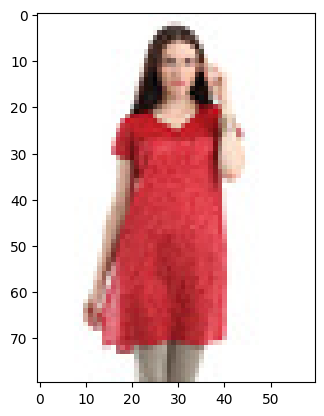

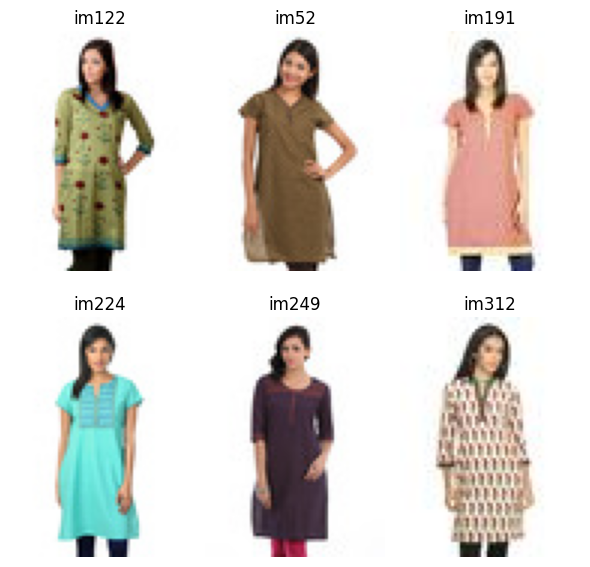

In [143]:

#Get recomender for summer season ehinic Kurtas for woman
idx_ref = 43
idx_rec, idx_sim = get_recommender_result(idx_ref, indices_swe,cos_summer_woman_ethinic,top_n = 6)
plot_figure(idx_ref,idx_rec, idx_sim,df_summer_woman_ethinic)


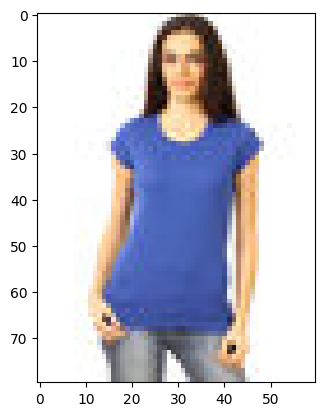

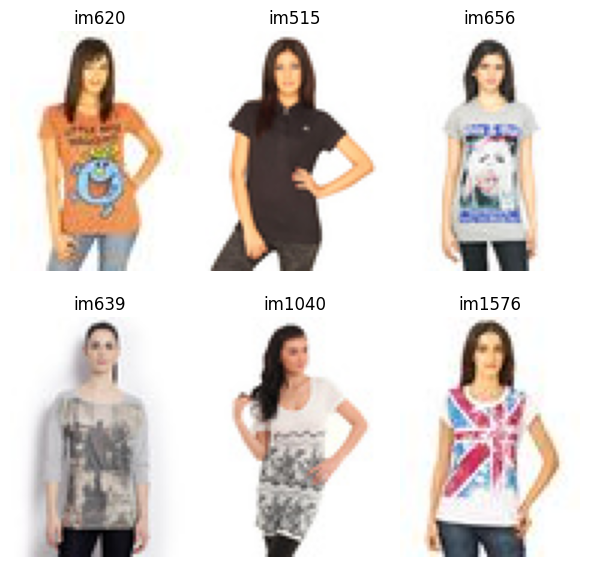

In [144]:
#Get recomender for Fall season casual T-Shirts for woman

idx_ref = 202
idx_rec, idx_sim = get_recommender_result(idx_ref, indices_fwc,cos_fall_woman_casual,top_n = 6)
plot_figure(idx_ref,idx_rec, idx_sim,df_fall_woman_casual)

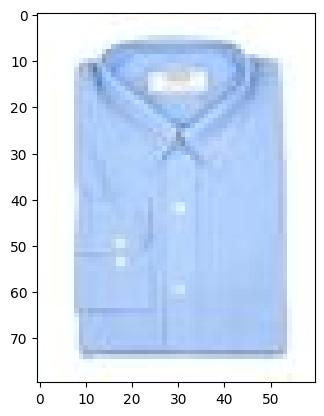

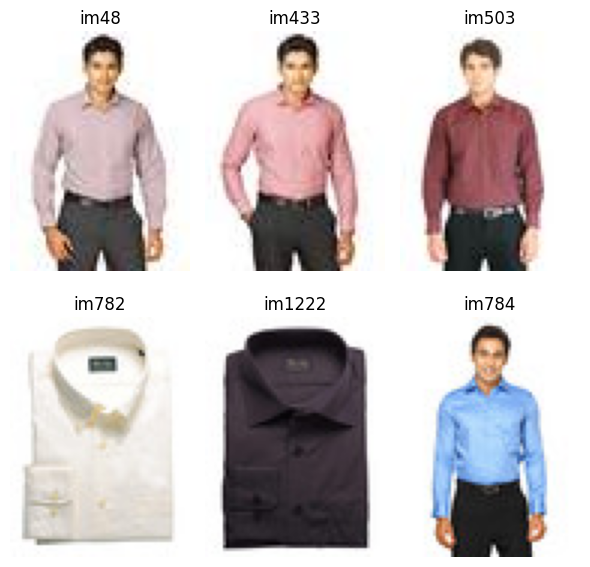

In [145]:
#Get recomender for Fall season casual Shirts for man

idx_ref = 15
idx_rec, idx_sim = get_recommender_result(idx_ref, indices_fmf,cos_fall_man_formal,top_n = 6)
plot_figure(idx_ref,idx_rec, idx_sim,df_fall_man_formal)

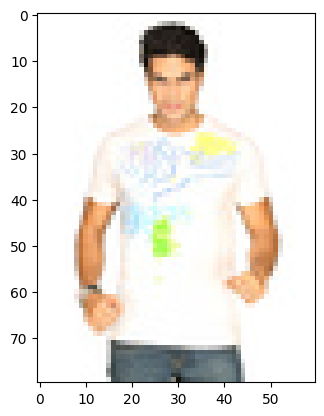

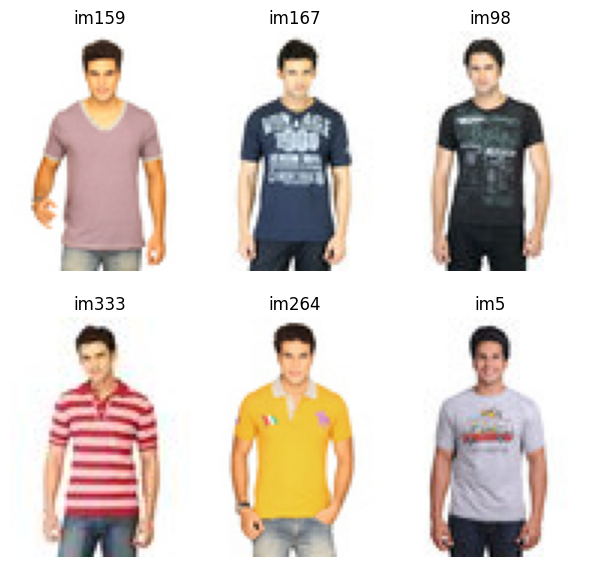

In [146]:
#Get recomender for Fall season casual T-Shirts for man

idx_ref = 82
idx_rec, idx_sim = get_recommender_result(idx_ref, indices_smc,cos_summer_man_casual,top_n = 6)
plot_figure(idx_ref,idx_rec, idx_sim,df_summer_man_casual)